In [1]:
import os
import platform
import random
import shutil
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras 
%matplotlib inline
random.seed(0)

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [2]:
# read in train, val, test dfs 
data_dir = './data/'
# diff sheets, so need to read in 
file_name = data_dir + 'processed_binary_data' 
train_df = pd.read_csv(file_name+'_train.csv', sep = ',').reset_index()
test_df = pd.read_csv(file_name+'_test.csv', sep = ',').reset_index()
train_df.head(5)

,index,Unnamed: 0,Unnamed: 0.1,On-Target Site,Off-Target Site,Score,Encoded Seqs
0,0,0,0,AAATGAGAAGAAGAGGCACAGGG,AAAAGAGAAGCTGAGGCACAGGG,1.0,KKKREKEKKEZREKEEPKPKEEE
1,1,1,1,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGAGGCATAGGG,1.0,KKKMEKEKKEKKEKEEPKMKEEE
2,2,2,2,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGCTGCACATGG,1.0,KKKMEKEKKEKKEZJEPKPKJEE
3,3,4,4,AAATGAGAAGAAGAGGCACAGGG,AAATCATATGAAGAGGCACAAGG,1.0,KKKLHKJKREKKEKEEPKPKYEE
4,4,5,5,AAATGAGAAGAAGAGGCACAGGG,AAATGAGAAAAATAGGCAGAGGG,1.0,KKKLEKEKKYKKJKEEPKHKEEE


In [3]:
# check lengths -- confirm all are same when comparing across datasets
seq_len = len(train_df['On-Target Site'][0])
print('Guide length: ', seq_len) # NOTE: WT seq is the reverse complement of guide 
print('Off-target:', len(train_df['Off-Target Site'][0]))

Guide length:  23
Off-target: 23


In [4]:
from pysster.One_Hot_Encoder import One_Hot_Encoder

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
new_alph_map = {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG':'J', 
                'CC': 'P', 'CG':'H', 'GG': 'E'}

new_alph = list(new_alph_map.values())

# one-hot encode
#modified code from Luis to get correct format for TPOT w/ my alphabet
one = One_Hot_Encoder(''.join(new_alph))
    
def _get_one_hot_encoding(seq):
    one_hot_seq = one.encode(seq)                         
    encoded_seq = np.argmax((one_hot_seq), axis=1) 
    return encoded_seq
    #return pd.get_dummies(
      #list(seq) + new_alph)[:-len(new_alph)].as_matrix().transpose()

# now convert the data into one_hot_encoding 
input_col_name = 'Encoded Seqs'
train_data = np.stack(
    [_get_one_hot_encoding(s) for s in train_df[input_col_name]]).astype(np.float32)
#val_data = np.stack(
    #[_get_one_hot_encoding(s) for s in val_df[input_col_name]]).astype(np.float32)
test_data = np.stack(
    [_get_one_hot_encoding(s) for s in test_df[input_col_name]]).astype(np.float32)

In [5]:
alph_len = len(new_alph)

from keras.utils import to_categorical

output_bin_col_name = 'Score'; 

# NOTE: need one-hot encoding of the labels 
train_bins = to_categorical(np.array(train_df[output_bin_col_name].astype(np.float32)))
#val_bins = to_categorical(np.array(val_df[output_bin_col_name].astype(np.float32)))
test_bins = to_categorical(np.array(test_df[output_bin_col_name].astype(np.float32)))

print('done')

done


In [8]:
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import keras as keras
from keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding
from keras.optimizers import SGD
from keras.regularizers import l2

def embed_model(embed_dim, hidden_layers, l2_coeff, dropout_rate):
    X_in = Input(shape=(seq_len,),dtype='float32')
    E = Embedding(alph_len,embed_dim,input_length=seq_len)(X_in)
    H = Flatten()(E)
    H = Dropout(dropout_rate)(H)
    for h in hidden_layers: 
        H = Dense(h, activation='relu', activity_regularizer = l2(l2_coeff))(H)
        H = Dropout(dropout_rate)(H)
#     H = Dense(1,activation="sigmoid",name='preds')(H)
    H = Dense(2,activation="softmax",name='preds')(H)
    model = Model(inputs=[X_in], outputs=H)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])#[precision,recall])#metrics=[sensitivity, specificity])
    return model

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define k-fold cross validation test harness
num_folds = 3
num_epochs = 20
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
all_scores = {}
X = train_data
y = train_bins


#embed_dims = [3,5]
#hidden_layer_choices = [(50,10), (50,), (30,)]
l2_coeffs = [0.0, 0.001, 0.01]
dropout_rates = [0.0, 0.2, 0.4]

for l2_coeff in l2_coeffs: 
    for dropout_rate in dropout_rates: 
        param_combo = (l2_coeff, dropout_rate)
        cvscores = []
        for train, test in kfold.split(X, y.argmax(1)):
          # create model
            model = embed_model(embed_dim=5, hidden_layers=(50,), l2_coeff = l2_coeff, dropout_rate = dropout_rate)
            #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=0, mode='auto', baseline=None)
            model.fit(X[train], y[train],epochs=num_epochs, batch_size=128,verbose=0)#,callbacks=[early_stopping])
            # evaluate the model

            y_pred = model.predict(X[test])
            y_true = y[test]

            y_true_labels = np.argmax(y[test], axis=1)
            y_pred_labels = np.argmax(y_pred, axis=1) 

            average_precision = average_precision_score(y_true, y_pred)
            auc = roc_auc_score(y_true_labels, y_pred_labels)
            acc = sklearn.metrics.accuracy_score(y_true_labels, y_pred_labels)
            f1_val = sklearn.metrics.f1_score(y_true_labels,y_pred_labels, average='macro')
            print('Average precision-recall score:', average_precision)
            print('AUC:', auc)
            print('Accuracy:', acc)
            print('F1:', f1_val)
            cvscores.append([average_precision, auc, acc, f1_val])
        all_scores[param_combo] = cvscores


Average precision-recall score: 0.8432861271328329
AUC: 0.8033157722873879
Accuracy: 0.9986150219670357
F1: 0.8025252089252046
Average precision-recall score: 0.8086375472060761
AUC: 0.7615090522013604
Accuracy: 0.9986241813879259
F1: 0.7853697780845901
Average precision-recall score: 0.8439950055674806
AUC: 0.7945163248084377
Accuracy: 0.9988443017656501
F1: 0.8197106109324759
Average precision-recall score: 0.840063649588493
AUC: 0.6675117026068714
Accuracy: 0.998780118686197
F1: 0.7449053921688409
Average precision-recall score: 0.8150005831761697
AUC: 0.6753283526121606
Accuracy: 0.9987342468768917
F1: 0.7460066959100657
Average precision-recall score: 0.8431135162913619
AUC: 0.6710250669168442
Accuracy: 0.9987984407246044
F1: 0.748741395785569
Average precision-recall score: 0.8035806486517574
AUC: 0.5863874345549738
Accuracy: 0.9985508176873619
F1: 0.6469587604357264
Average precision-recall score: 0.7878474185495741
AUC: 0.596854044633105
Accuracy: 0.9985783207675234
F1: 0.66121

/Users/kcollins/anaconda3/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.49999999200770684
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473


/Users/kcollins/anaconda3/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945


/Users/kcollins/anaconda3/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435


/Users/kcollins/anaconda3/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473


/Users/kcollins/anaconda3/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945


/Users/kcollins/anaconda3/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473


/Users/kcollins/anaconda3/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
d = pd.DataFrame.from_dict(all_scores)
d.to_csv('embed_grid_search_all_part2.csv')

In [12]:
cv_means = {k:sum(np.array(v)/num_folds) for k,v in all_scores.items()}

In [13]:
cv_means

{(0.0, 0.0): array([0.83197289, 0.78644705, 0.9986945 , 0.8025352 ]),
 (0.0, 0.2): array([0.83272592, 0.67128837, 0.99877094, 0.74655116]),
 (0.0, 0.4): array([0.79824623, 0.5944123 , 0.99857526, 0.65792089]),
 (0.001, 0.0): array([0.83775976, 0.74117291, 0.99879234, 0.7888993 ]),
 (0.001, 0.2): array([0.80868607, 0.61890328, 0.99864864, 0.68969334]),
 (0.001, 0.4): array([0.78813711, 0.58652368, 0.9985508 , 0.64685725]),
 (0.01, 0.0): array([0.71058534, 0.62647652, 0.99859361, 0.67225035]),
 (0.01, 0.2): array([0.5       , 0.5       , 0.99825118, 0.49956241]),
 (0.01, 0.4): array([0.5       , 0.5       , 0.99825118, 0.49956241])}

<BarContainer object of 9 artists>

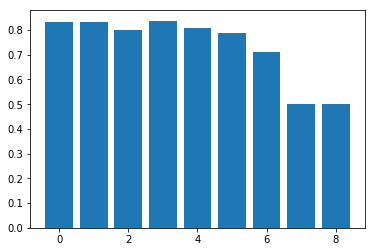

In [14]:
cv_means_df = pd.DataFrame.from_dict(cv_means)
param_combos = list(cv_means.keys())
score_vals = [cv_means[k][0] for k in param_combos]
plt.bar(range(len(param_combos)),score_vals)

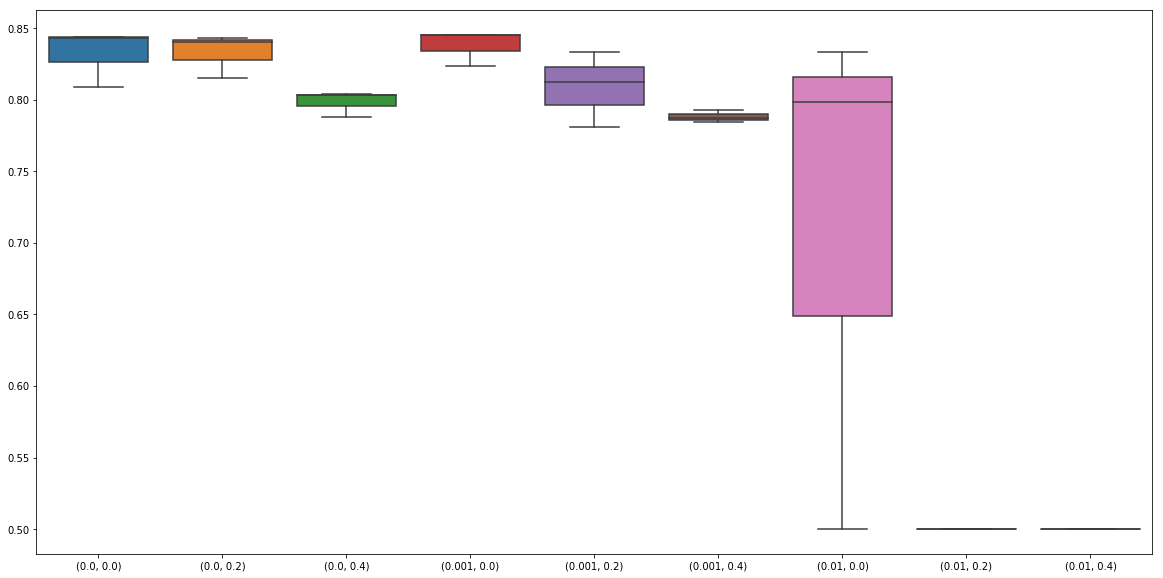

In [17]:
prec_recall_scores = []
for params in param_combos:
    folds = all_scores[params]
    prec_recall_scores.append([fold[0] for fold in folds])
param_combos_str = [str(params) for params in param_combos]
plt.figure(figsize=(20,10))
sns.boxplot(param_combos_str, prec_recall_scores)

In [ ]:
# best => embed_dim = 5, hidden_layers = (50,), l2 = 0.001, dropout_rate = 0.0 
# plot above shows the big impact of l2 regularizer; especially coupled w/ dropout rate (though that is less impact)